## Converting Images from grayscale to Color.

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn
from PIL import Image

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'#small-256
path_lr = path/'old'#small-96
path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [3]:
il = ImageList.from_folder(path_hr)

In [4]:
il.items

array([PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/pomeranian_123.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Bengal_87.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Ragdoll_52.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_54.jpg'), ...,
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/saint_bernard_171.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/saint_bernard_24.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Siamese_63.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_207.jpg')], dtype=object)

In [5]:
len(il.items)

7390

In [6]:
img = open_image(path/'images/pomeranian_123.jpg')
img.show()

In [7]:
# Converting a colored image to b/w
# dithering =True adds some noise to the image.
def black_white(fn, i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = Image.open(fn)
    img = img.convert('L')
    q=75 #which is default.the image quality is decreased.ranges from 0 to 95.
    img.save(dest, quality=q)

Uncomment the first time you run this nb

In [8]:
#parallel(black_white, il.items)

In [9]:
import os
os.listdir(path_lr)

['pomeranian_123.jpg',
 'Bengal_87.jpg',
 'Ragdoll_52.jpg',
 'wheaten_terrier_54.jpg',
 'samoyed_165.jpg',
 'Egyptian_Mau_87.jpg',
 'Sphynx_189.jpg',
 'Bengal_116.jpg',
 'Siamese_185.jpg',
 'staffordshire_bull_terrier_93.jpg',
 'pomeranian_9.jpg',
 'basset_hound_122.jpg',
 'chihuahua_152.jpg',
 'Ragdoll_210.jpg',
 'British_Shorthair_145.jpg',
 'Maine_Coon_35.jpg',
 'Ragdoll_34.jpg',
 'British_Shorthair_180.jpg',
 'keeshond_189.jpg',
 'Abyssinian_19.jpg',
 'newfoundland_165.jpg',
 'pomeranian_137.jpg',
 'Persian_58.jpg',
 'Russian_Blue_211.jpg',
 'basset_hound_120.jpg',
 'pomeranian_129.jpg',
 'Maine_Coon_126.jpg',
 'japanese_chin_185.jpg',
 'samoyed_71.jpg',
 'japanese_chin_143.jpg',
 'samoyed_110.jpg',
 'saint_bernard_102.jpg',
 'chihuahua_33.jpg',
 'pomeranian_183.jpg',
 'basset_hound_58.jpg',
 'Ragdoll_136.jpg',
 'scottish_terrier_43.jpg',
 'beagle_23.jpg',
 'great_pyrenees_160.jpg',
 'boxer_25.jpg',
 'english_setter_158.jpg',
 'boxer_48.jpg',
 'boxer_32.jpg',
 'havanese_167.jpg',
 

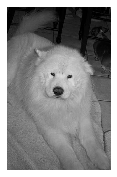

In [10]:
img = open_image(path_lr/'samoyed_165.jpg')
img.show()

In [11]:
bs, size = 32, 128
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=12)

In [12]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=1.5), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3 #rgb
    return data

In [13]:
data = get_data(bs, size)

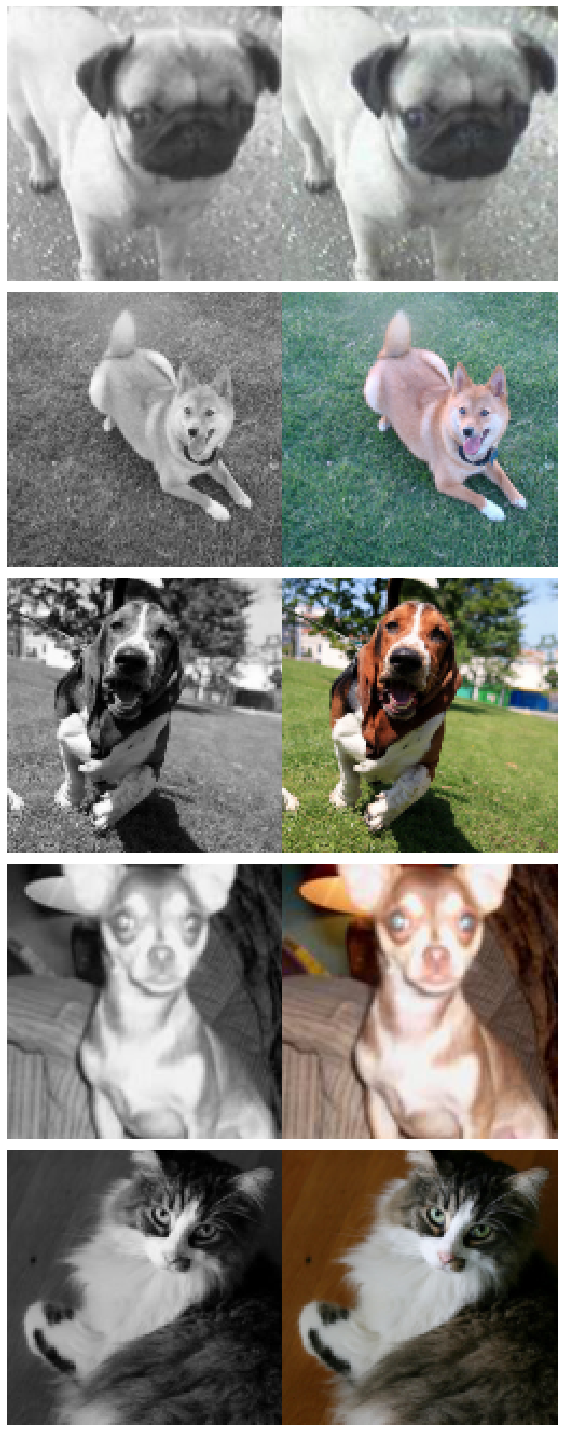

In [14]:
data.show_batch()

# Feature Loss

In [14]:
t = data.valid_ds[0][1].data; t.shape

torch.Size([3, 128, 128])

torch.stack concatenates two rtensors along a new dimension  
So if A and B are of shape (3, 4), torch.cat([A, B], dim=0) will be of shape (6, 4) and torch.stack([A, B], dim=0) will be of shape (2, 3, 4)

In [15]:
t = torch.stack([t,t]); t.shape

torch.Size([2, 3, 128, 128])

In [16]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [17]:
n,c,h,w = t.size()
x = t.view(n,c,-1)
x.shape

torch.Size([2, 3, 16384])

In [18]:
x.transpose(1,2).shape

torch.Size([2, 16384, 3])

In [19]:
y = gram_matrix(t)
y.shape

torch.Size([2, 3, 3])

In [20]:
gram_matrix(t)

tensor([[[0.0824, 0.0752, 0.0621],
         [0.0752, 0.0690, 0.0573],
         [0.0621, 0.0573, 0.0484]],

        [[0.0824, 0.0752, 0.0621],
         [0.0752, 0.0690, 0.0573],
         [0.0621, 0.0573, 0.0484]]])

In [21]:
base_loss = F.l1_loss # can be either mse or l1

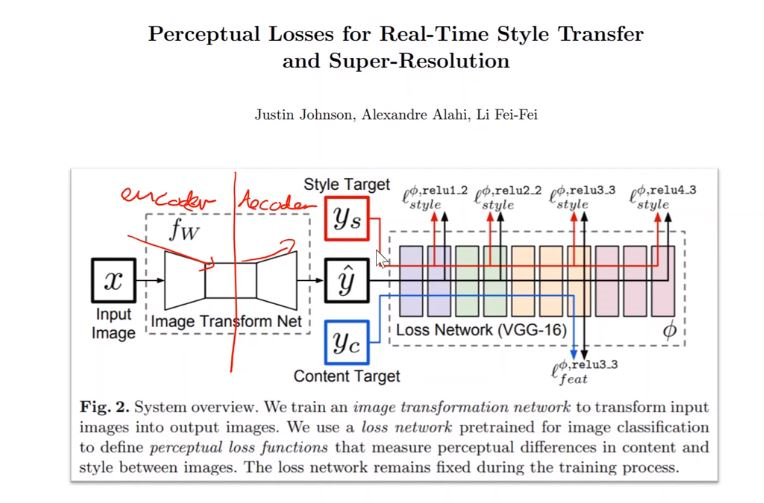

In [22]:
# vgg_bn is the pretrained model. The function .features in vgg contains the convolution part of the model.
# So we select that part of the model as we don't need the head of the model but only the intermediate activations
# We chuck it on the gpu and put into eval mode as we're not training it.
vgg_m = vgg16_bn(True).features.cuda().eval() 
requires_grad(vgg_m, False) #  we dont want to update the weights as we're just using in inference for calculating loss; 
# Hence we set it to False

In [23]:
# The grid size of the tensors changes in the max pooling layers of the vgg model.
# We wanna grab features from everytime just before the grid size changes hence the layer (i-1)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)] 
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

The output above is the list of the layer numbers just before the max pooling layers in the variable blocks.

In [24]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat # the pretrained model. model which contains the features on which we want our feature losses
        self.loss_features = [self.m_feat[i] for i in layer_ids] # grabbing all layers from the network that we want features for
        self.hooks = hook_outputs(self.loss_features, detach=False) # grabbing intermediate layers by hooking 'em
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True) # passes target(actual y) to make_features which then calls the vgg model and go through all stored activations and grab a copy of em
        in_feat = self.make_features(input) # same thing for ip(which is the o/p of the generator).
        self.feat_losses = [base_loss(input,target)] # calculating l1 loss between the pixels as we still want it a little bit
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)] # going thorugh all the features and getting the l1 loss on them by grabbing the activations on each of them
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses) # summing them all up
    
    def __del__(self): self.hooks.remove()

In [25]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [26]:
# the callback_fns prints out all the losses of different layers
# blur and norm_type in Part2
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


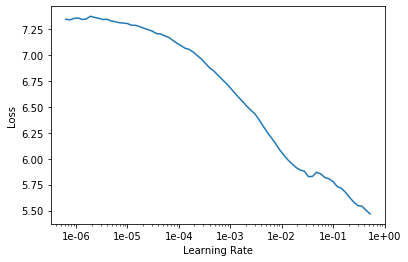

In [35]:
learn.lr_find()
learn.recorder.plot()

In [27]:
lr = 1e-2

In [28]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

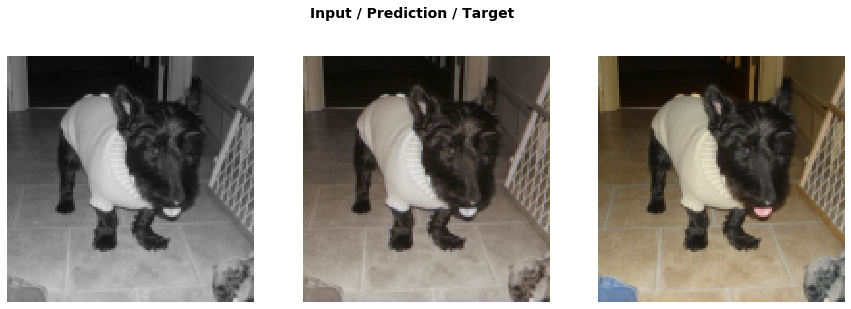

In [40]:
do_fit('1a', slice(lr*10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


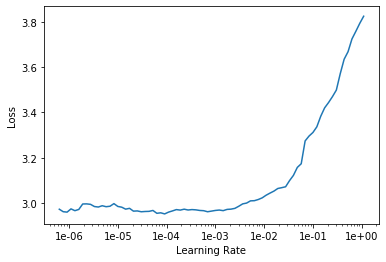

In [41]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [42]:
do_fit('1b', slice(1e-5, 1e-3))

In [32]:
data = get_data(24, 172)

In [29]:
learn.data = data
learn.freeze()
gc.collect()

244

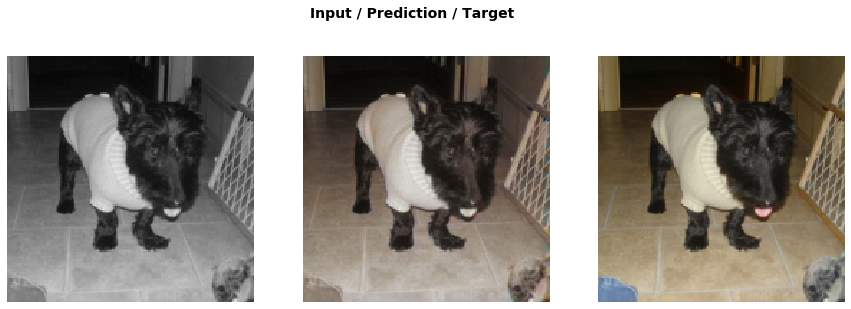

In [45]:
do_fit('2a', slice(lr*10, lr))

In [30]:
learn.load('2a');

In [33]:
learn.unfreeze()

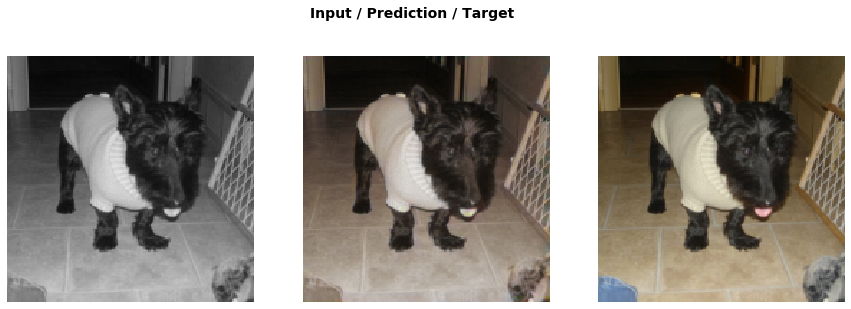

In [37]:
do_fit('2b', slice(1e-5, 1e-3))

In [30]:
data = get_data(16, 224)

In [31]:
learn.data = data
learn.freeze()
gc.collect()

153

In [40]:
do_fit('3a', slice(lr*10, lr))

In [41]:
learn.unfreeze()
do_fit('3b', slice(1e-5, 1e-3))

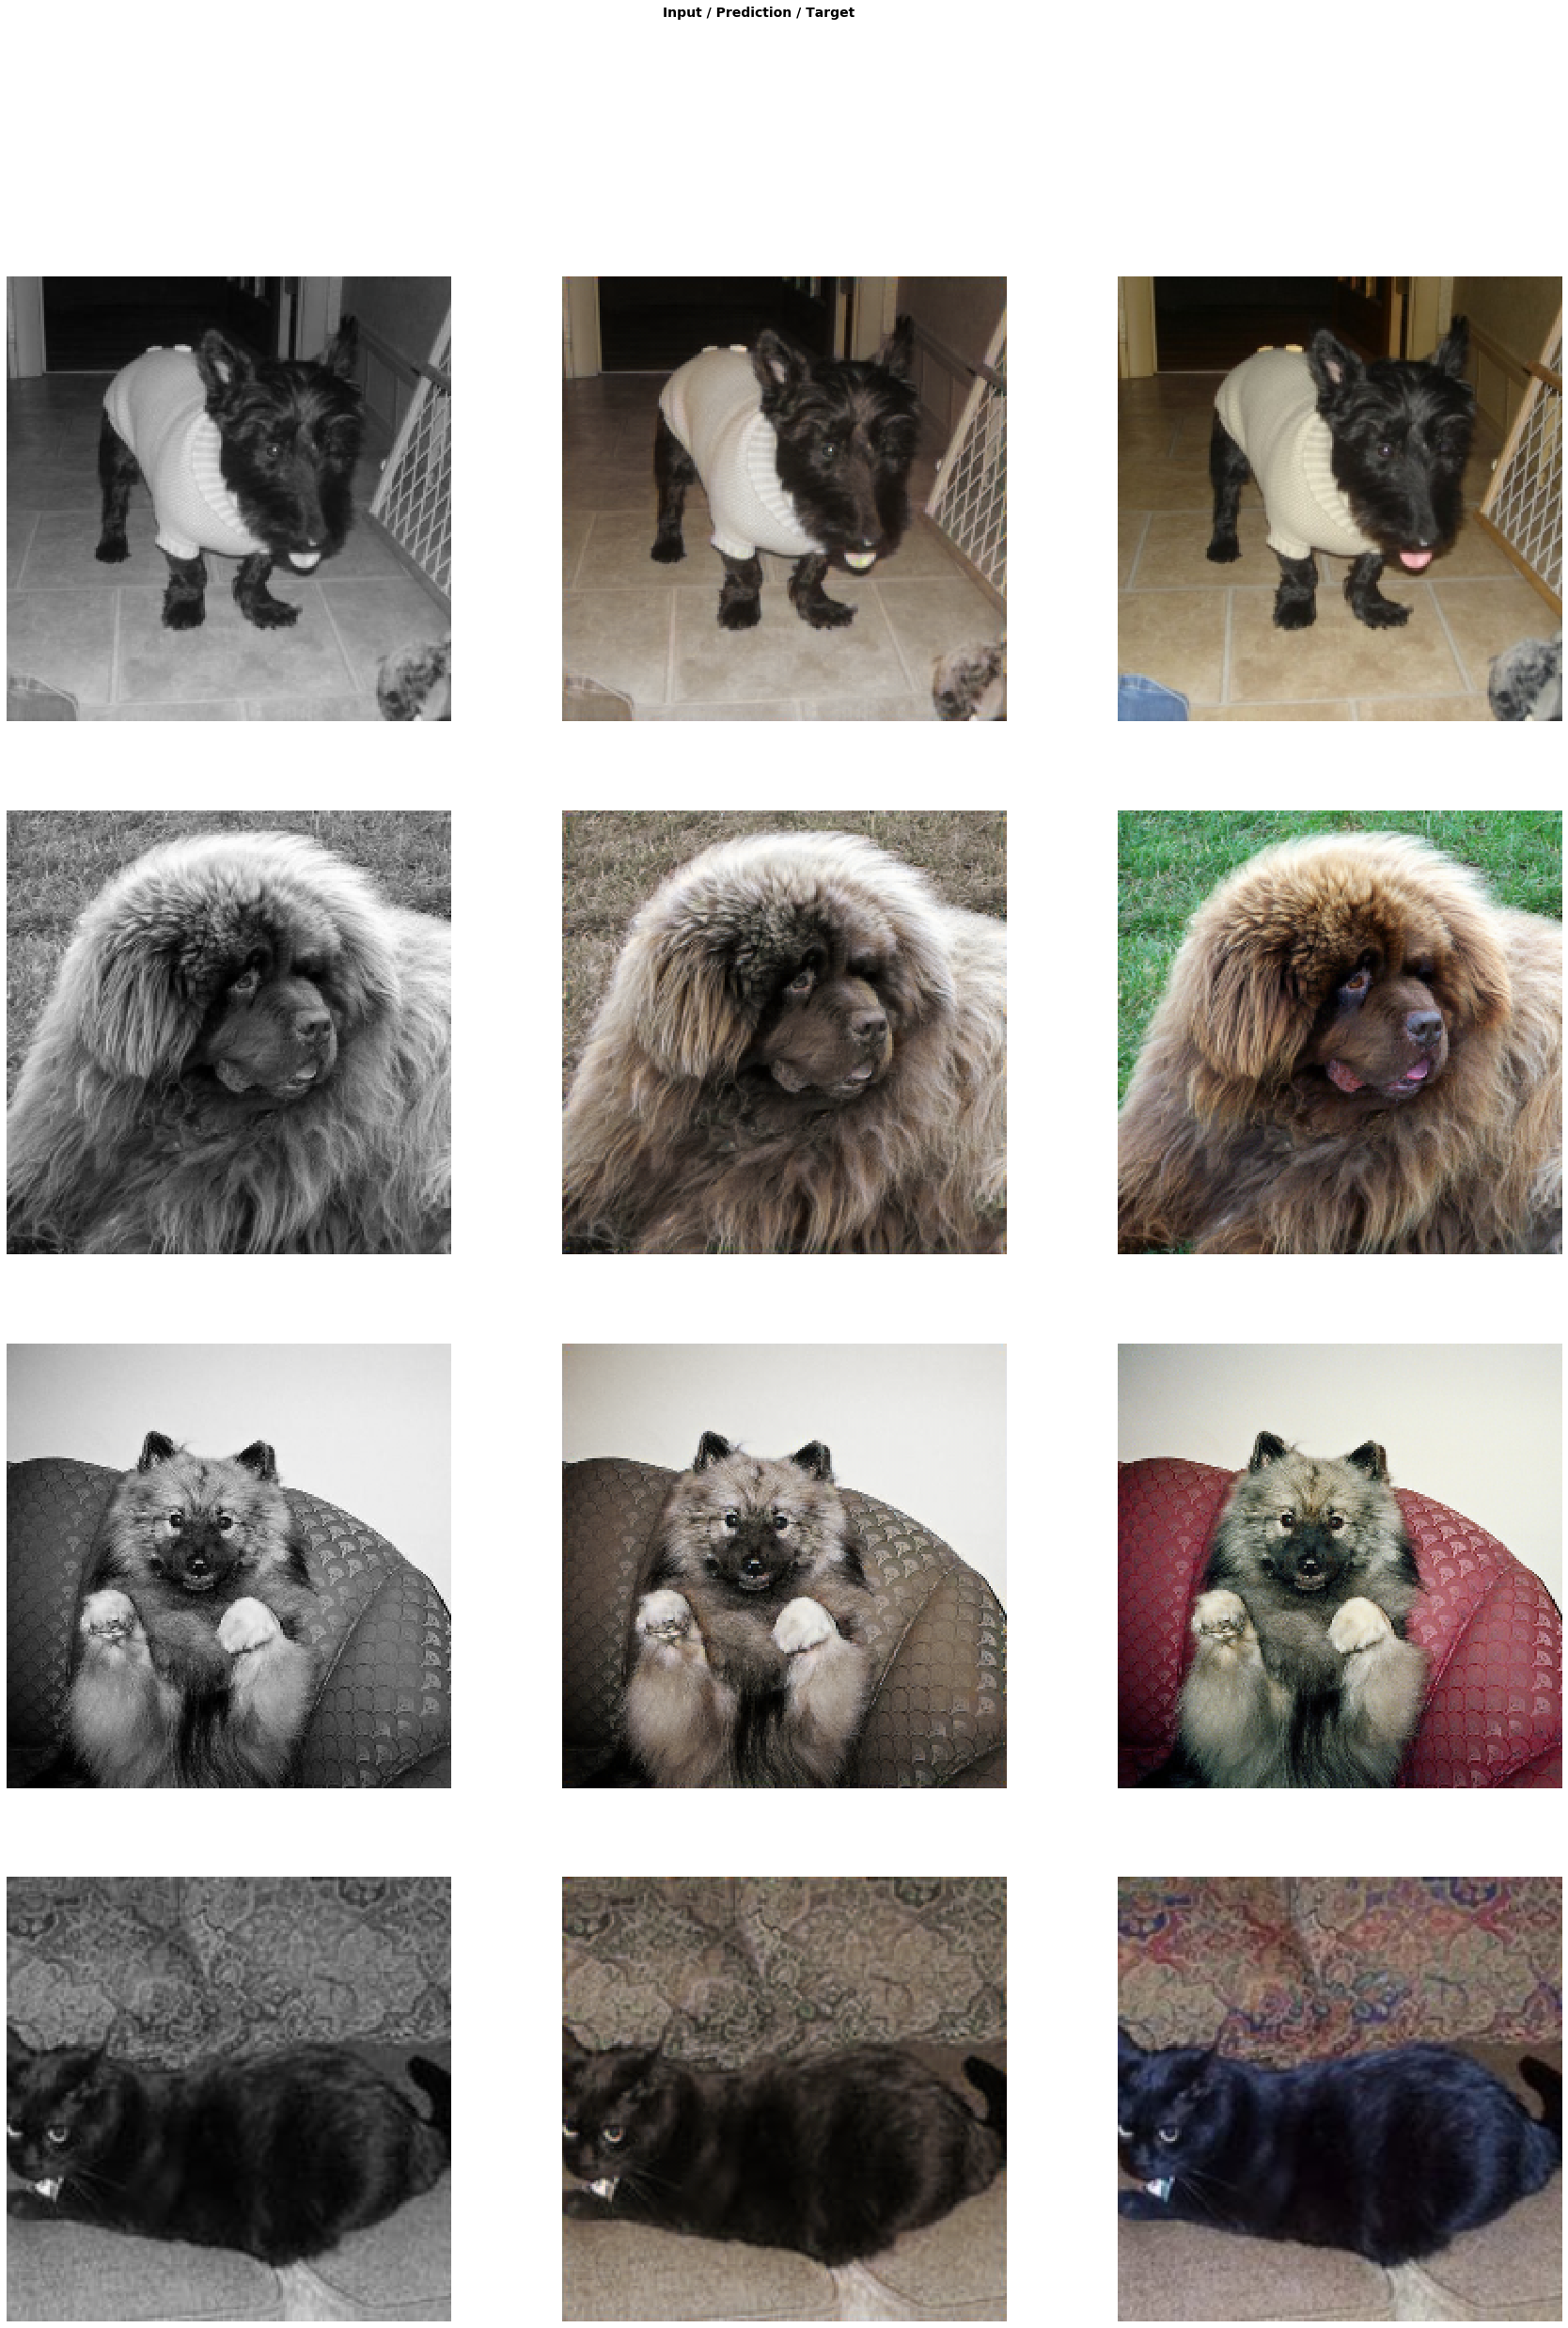

In [42]:
learn.show_results(rows=4, imgsize=10)

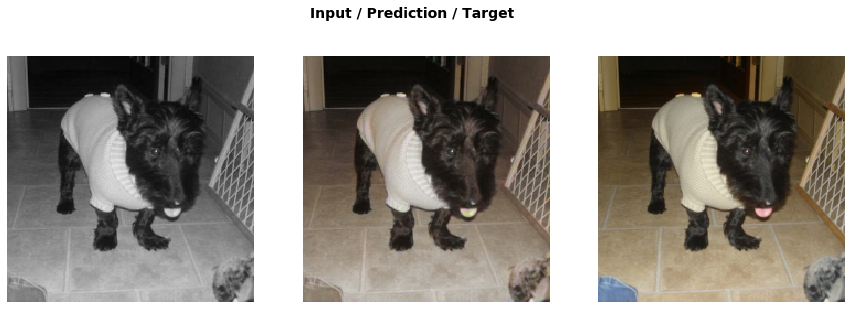

In [43]:
do_fit('3c', slice(1e-6, 1e-4))

In [31]:
data = get_data(16, 256)

In [32]:
learn.data = data
learn.freeze()
gc.collect()

7045

In [34]:
do_fit('4a', slice(lr*10, lr))

In [35]:
learn.unfreeze()
do_fit('4b', slice(1e-6, 1e-4))

In [29]:
data = get_data(4, 512)

In [30]:
learn.load('4b');

In [31]:
learn.data = data
learn.freeze()
gc.collect()

20

In [ ]:
do_fit('5a', slice(lr*10, lr))